### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars,LassoLarsCV
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt


In [3]:
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV

In [4]:
#import sys
#sys.path.append(os.path.abspath('..'))#sys.path[0] + '/..') 
from vb_estimators import LinRegSupreme,LinSVR,RBFSVR,ENet,L1Lars
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv

no daal4py


In [5]:

from warnings import filterwarnings
filterwarnings('ignore')


In [6]:
gridpoints=5
test_share=0.2
cv_folds=5
cv_reps=10
cv_count=cv_folds*cv_reps
group_count=5 # for stratified cv
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

In [7]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
#cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
cv=regressor_q_stratified_cv(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs,group_count=group_count,strategy='quantile')

vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

##### Example Dataset

In [8]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [9]:
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]
X_df=df.loc[:,x_vars]
y_df=df.loc[:,y_name]

In [10]:

shuf=np.arange(y_df.shape[0])
np.random.seed(0)
np.random.shuffle(shuf)
X_df=X_df.iloc[shuf]
y_df=y_df.iloc[shuf]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_share,random_state=rs)
    


In [12]:
estimator_dict={
    'lin-reg-supreme':lambda: LinRegSupreme(gridpoints=gridpoints),
    'elastic-net':lambda: ENet(gridpoints=gridpoints), 
    'linear-svr-cv':lambda: LinSVR(gridpoints=gridpoints,), 
    'rbf-svr-cv':lambda: RBFSVR(gridpoints=gridpoints), 
    'lassolars':L1Lars,
    #'gradient-boosting-reg':gradient_boosting_reg
   }
vbhelper.estimator_dict=estimator_dict
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [13]:
i=0
for name,est in model_dict.items():
    start=time()
    i+=1;print(name)
    est.fit(X_train,y_train)
    print('train R2:',est.score(X_train,y_train))
    if not X_test is None:print('test R2:',est.score(X_test,y_test))
    end=time()
    print(f'runtime:{(end-start)/60} min.\n')


lin-reg-supreme
train R2: 0.5467045013907661
test R2: 0.3903621844571947
runtime:0.0426055630048116 min.

elastic-net
train R2: 0.4905033969347208
test R2: 0.34721720527893984
runtime:0.38432159821192424 min.

linear-svr-cv
train R2: 0.5394815974211529
test R2: 0.3837139743018927
runtime:0.1957554817199707 min.

rbf-svr-cv
train R2: 0.7179628490413851
test R2: 0.41526530117313887
runtime:0.10186315377553304 min.

lassolars
train R2: 0.4778338536591311
test R2: 0.3426981377676046
runtime:0.02445896863937378 min.



In [14]:
cv_results={}
for estimator_name,model in model_dict.items():
    start=time()
    model_i=cross_validate(model, X_df, y_df, return_estimator=True, scoring=scorer_list, cv=cv, n_jobs=4)
    end=time()
    print(f"{estimator_name},{[(scorer,np.mean(model_i[f'test_{scorer}'])) for scorer in scorer_list]}, runtime:{(end-start)/60} min.")
    cv_results[estimator_name]=model_i
            
# replace with a loop in order to save the residuals for a graph?

lin-reg-supreme,[('neg_mean_squared_error', -8051.302765651769), ('neg_mean_absolute_error', -66.00362320696452), ('r2', 0.39884618074136424)], runtime:0.8028192559878031 min.
elastic-net,[('neg_mean_squared_error', -8055.037670078463), ('neg_mean_absolute_error', -66.0009708285515), ('r2', 0.4035126584222074)], runtime:5.156274159749349 min.
linear-svr-cv,[('neg_mean_squared_error', -8327.073931491906), ('neg_mean_absolute_error', -63.80339152994404), ('r2', 0.38111612004031015)], runtime:3.668509781360626 min.
rbf-svr-cv,[('neg_mean_squared_error', -7412.034067379738), ('neg_mean_absolute_error', -60.29941073686644), ('r2', 0.4532231780478665)], runtime:1.6212158044179281 min.
lassolars,[('neg_mean_squared_error', -7889.144540154097), ('neg_mean_absolute_error', -65.09547192780704), ('r2', 0.41553969086048786)], runtime:0.3419921398162842 min.


#### graphs and table to summarize results

In [15]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [16]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    lin-reg-supreme:-8051.302765651769
    elastic-net:-8055.037670078463
    linear-svr-cv:-8327.073931491906
    rbf-svr-cv:-7412.034067379738
    lassolars:-7889.144540154097
scores for scorer: neg_mean_absolute_error:
    lin-reg-supreme:-66.00362320696452
    elastic-net:-66.0009708285515
    linear-svr-cv:-63.80339152994404
    rbf-svr-cv:-60.29941073686644
    lassolars:-65.09547192780704
scores for scorer: r2:
    lin-reg-supreme:0.39884618074136424
    elastic-net:0.4035126584222074
    linear-svr-cv:0.38111612004031015
    rbf-svr-cv:0.4532231780478665
    lassolars:0.41553969086048786


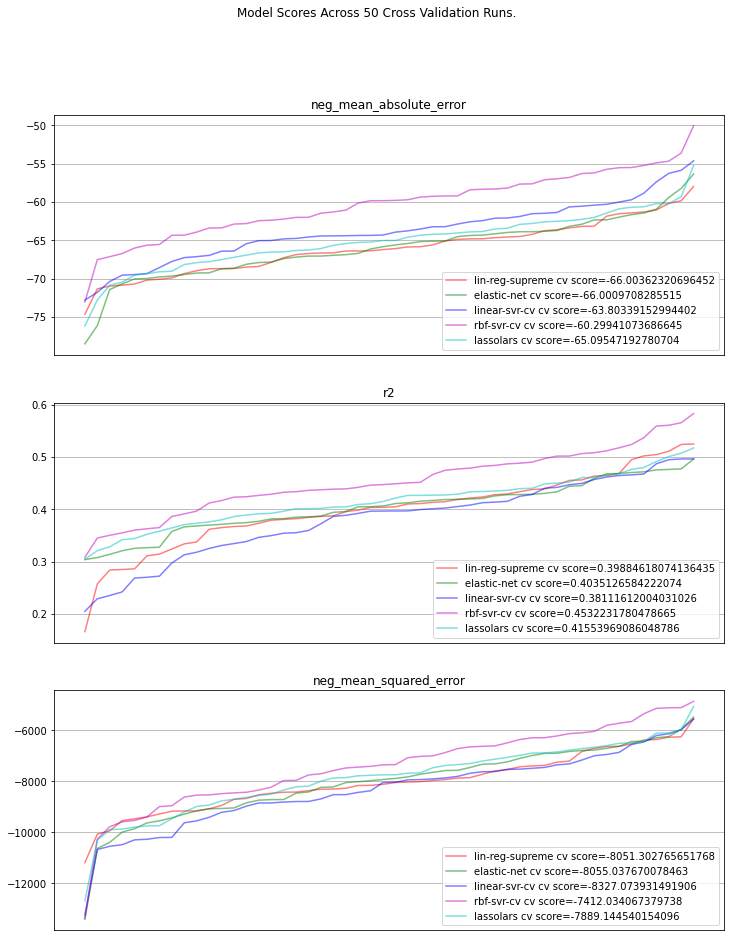

In [17]:
vbhelper.plotCVScores(cv_score_dict,sort=1)